
# USA Unemployment analysis with ScikitLearn RF Regressor



In [1]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code."></form>''')


## 0. Import

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from numpy import corrcoef
from time import clock

from sklearn import tree
from sklearn.tree import export_graphviz



## 1. Data input



In [3]:

##  Unemployment rates  //words dataset

unemp = pd.read_csv("unemp_small.csv", sep="\t", header = None)
unemp.columns = ["fips", "pop", "unempRateWords"]

unempPivot = unemp.pivot_table(index="fips",values=["unempRateWords","pop"]).copy()
unempPivot.drop_duplicates(subset="pop", keep=False, inplace=True)

print(unempPivot.head(), '\n\n', unempPivot.shape)

         pop  unempRateWords
fips                        
1003  200111          5.9250
1005   26887         11.4750
1007   22506          7.1000
1009   57719          6.0625
1011   10764         11.7500 

 (2956, 2)


In [4]:

##  Unemployment rates  //acticity dataset

unemp2 = pd.read_table("laucnty14.txt",sep=r'\s{2,}',header=None,usecols=[1,2,5,6,7,8,9],
         converters={1: np.str, 2: np.str, 8: np.float64})
#print(unemp2.head(),'\n\n')

unemp2.columns = ["fip1", "fip2", "laborForce", "employed", "unemployed", "unempRateAct"]
unemp2["fips"] = unemp2["fip1"] + unemp2["fip2"]
unemp2["fips"] = unemp2["fips"].astype(int)
unemp2["laborForce"] = unemp2["laborForce"].apply(lambda s: s.replace(',','')).astype(int)
unemp2["unemployed"] = unemp2["unemployed"].apply(lambda s: s.replace(',','')).astype(int)
unemp2["employed"] = unemp2["employed"].apply(lambda s: s.replace(',','')).astype(int)

unemp2Pivot = unemp2.pivot_table(index="fips", values=["unempRateAct","employed"]).copy()

print(unemp2Pivot.head(), '\n\n', unemp2Pivot.shape)

      employed  unempRateAct
fips                        
1001     24111           5.9
1003     81131           6.1
1005      7917          10.6
1007      7946           7.2
1009     23036           6.1 

 (3219, 2)


C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [5]:

##  Unemployment Data  //merge

# ! Unemployment rate based on labor force, employment rate based on population !
# ! activity dataset and words dataset has different unemployment rates !

unempData = pd.merge(unempPivot,unemp2Pivot, how='inner', left_index=True, right_index=True).copy()
#print(unempData.head(),'\n\n')

unempData["empRate"] = 100 * unempData["employed"] / unempData["pop"]
unempData.drop(["pop","employed"], axis=1, inplace=True)
unempData.sort_index(level=0, axis=0, ascending=True, inplace=True, sort_remaining=False)
unempData.sort_index(level=0, axis=1, ascending=True, inplace=True, sort_remaining=False)

print(unempData.head(), '\n\n', unempData.shape)

        empRate  unempRateAct  unempRateWords
fips                                         
1003  40.542999           6.1          5.9250
1005  29.445457          10.6         11.4750
1007  35.306141           7.2          7.1000
1009  39.910601           6.1          6.0625
1011  40.096618           8.8         11.7500 

 (2954, 3)


In [6]:

##  Word frequency Data (BIG FILE !!!)

words = pd.read_csv("unemp_training_set.csv", header = None)
words.columns = ["fips", "word", "cnt", "totcnt"]
words["word"] = words["word"].apply(lambda s: s.lower())
words["freq"] = words.apply(lambda row: row["cnt"]/row["totcnt"], axis = 1)

print(words.head(), '\n\n', words.shape)

    fips     word  cnt   totcnt      freq
0  48473    aaron    2    95626  0.000021
1  39095     abby   17   816992  0.000021
2  34033  ability    5   113270  0.000044
3   1127    aaron    5    90625  0.000055
4   6071     abby   30  3152613  0.000010 

 (6557665, 5)


In [7]:
wordsPivot = words.pivot_table(columns="word",index="fips",values="freq").copy()
wordsPivot.fillna(0, inplace=True)
wordsPivot.sort_index(level=0, axis=0, ascending=True, inplace=True, sort_remaining=False)
wordsPivot.sort_index(level=0, axis=1, ascending=True, inplace=True, sort_remaining=False)
#print(wordsPivot.head(),'\n\n')

wordsData = pd.merge(unempData ,wordsPivot, how='inner', left_index=True, right_index=True).copy()
wordsData.drop("unempRateAct", axis=1, inplace=True)
wordsData.sort_index(level=0, axis=0, ascending=True, inplace=True, sort_remaining=False)

print(wordsData.head(), '\n\n', wordsData.shape)

        empRate  unempRateWords     aaron      abby   ability      able  \
fips                                                                      
1003  40.542999          5.9250  0.000042  0.000021  0.000017  0.000431   
1009  39.910601          6.0625  0.000026  0.000052  0.000052  0.000442   
1013  41.791486          8.7875  0.000000  0.000034  0.000034  0.000309   
1015  37.520273          7.7000  0.000014  0.000024  0.000005  0.000360   
1017  41.921000          7.1125  0.000000  0.000015  0.000015  0.000362   

         about     above  absolute  absolutely    ...         youu     yummy  \
fips                                              ...                          
1003  0.005418  0.000088  0.000029    0.000222    ...     0.000050  0.000038   
1009  0.006998  0.000000  0.000026    0.000364    ...     0.000104  0.000000   
1013  0.006377  0.000240  0.000000    0.000069    ...     0.000000  0.000000   
1015  0.005733  0.000072  0.000077    0.000163    ...     0.000091  0.0000

In [8]:

##  Activity data

activ = pd.read_csv("raw_data.csv", sep=",", header = None)
activ.columns = ["fips", "hour", "activity"]
#print(activ.head(), "\n\n")

activPivot = activ.pivot_table(index="fips", columns="hour", values="activity").copy()
activPivot.fillna(0, inplace=True)
activPivot.sort_index(level=0, axis=1, ascending=True, inplace=True, sort_remaining=False)
#print(activPivot.head(), "\n\n")

activPivot["messageCount"] = activPivot.sum(numeric_only=True, axis=1)
activPivot = activPivot[activPivot["messageCount"] > 1800]
activPivot.iloc[:,:-1] = activPivot.iloc[:,:-1].div(activPivot["messageCount"], axis=0)
#print(activPivot.head(), "\n\n")

activData = pd.merge(unempData ,activPivot, how='inner', left_index=True, right_index=True).copy()
activData.drop("unempRateWords", axis=1, inplace=True)
activData.sort_index(level=0, axis=0, ascending=True, inplace=True, sort_remaining=False)

print(activData.head(), '\n\n', activData.shape)

        empRate  unempRateAct         0         1         2         3  \
fips                                                                    
1003  40.542999           6.1  0.068764  0.048920  0.027950  0.015420   
1007  35.306141           7.2  0.049163  0.040795  0.030858  0.031381   
1009  39.910601           6.1  0.057902  0.038271  0.022435  0.008743   
1013  41.791486           8.6  0.055371  0.036446  0.022954  0.012616   
1015  37.520273           8.0  0.074314  0.064947  0.043261  0.027678   

             4         5         6         7      ...             15  \
fips                                              ...                  
1003  0.008567  0.005472  0.011456  0.020228      ...       0.038333   
1007  0.020921  0.007845  0.019874  0.022490      ...       0.042887   
1009  0.005279  0.005444  0.016331  0.019630      ...       0.041405   
1013  0.005782  0.006133  0.019450  0.023655      ...       0.043806   
1015  0.013726  0.008691  0.010576  0.015330      ...   

## 2. Data for ML

In [9]:

##  WordsData

labelWordsUnemp = (wordsData.unempRateWords.as_matrix()).copy()
print ("labelWordsUnemp: ", labelWordsUnemp[:5], labelWordsUnemp.shape,"\n")

labelWordsEmp = (wordsData.empRate.as_matrix()).copy()
print ("labelWordsEmp: ", labelWordsEmp[:5], labelWordsEmp.shape,"\n")

featuresWords_list = wordsData.columns.values[2:].copy()
print ("featuresWords_list: ", featuresWords_list, featuresWords_list.shape,"\n")

featuresWords = (wordsData.iloc[:,2:].as_matrix()).copy()
print ("featuresWords: \n", featuresWords[:5,:3], featuresWords.shape,"\n")

fipsWords_list = (wordsData.index.values[:]).copy()
print ("fipsWords_list: ", fipsWords_list[:5], fipsWords_list.shape,"\n")

labelWordsUnemp:  [ 5.925   6.0625  8.7875  7.7     7.1125] (1301,) 

labelWordsEmp:  [ 40.54299864  39.91060136  41.79148601  37.5202733   41.92100012] (1301,) 

featuresWords_list:  ['aaron' 'abby' 'ability' ..., 'zombie' 'zombies' 'zone'] (5985,) 

featuresWords: 
 [[  4.18366280e-05   2.09183140e-05   1.67346512e-05]
 [  2.60132147e-05   5.20264294e-05   5.20264294e-05]
 [  0.00000000e+00   3.42829716e-05   3.42829716e-05]
 [  1.44050014e-05   2.40083357e-05   4.80166714e-06]
 [  0.00000000e+00   1.50847764e-05   1.50847764e-05]] (1301, 5985) 

fipsWords_list:  [1003 1009 1013 1015 1017] (1301,) 



In [10]:

##  ActivData

labelActivUnemp = (activData.unempRateAct.as_matrix()).copy()
print ("labelActivUnemp: ", labelActivUnemp[:5], labelActivUnemp.shape,"\n")

labelActivEmp = (activData.empRate.as_matrix()).copy()
print ("labelActivEmp: ", labelActivEmp[:5], labelActivEmp.shape,"\n")

featuresActiv_list = (activData.columns.values[2:-1]).copy()
print ("featuresActiv_list: ", featuresActiv_list, featuresActiv_list.shape,"\n")

featuresActiv = (activData.iloc[:,2:-1].as_matrix()).copy()
print ("featuresActiv: \n", featuresActiv[:5,:3], featuresActiv.shape,"\n")

fipsActiv_list = (activData.index.values[:]).copy()
print ("fipsActiv_list: ", fipsActiv_list[:5], fipsActiv_list.shape,"\n")

#weight = (activData.iloc[:,-1].as_matrix()).copy()
#print ("weight: ", weight[:5], weight.shape,"\n")

labelActivUnemp:  [ 6.1  7.2  6.1  8.6  8. ] (1823,) 

labelActivEmp:  [ 40.54299864  35.30614058  39.91060136  41.79148601  37.5202733 ] (1823,) 

featuresActiv_list:  [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] (24,) 

featuresActiv: 
 [[ 0.06876359  0.04891958  0.02795039]
 [ 0.04916318  0.04079498  0.03085774]
 [ 0.05790168  0.0382712   0.02243484]
 [ 0.0553706   0.03644647  0.02295427]
 [ 0.07431368  0.06494712  0.04326058]] (1823, 24) 

fipsActiv_list:  [1003 1007 1009 1013 1015] (1823,) 



In [11]:
##  All output data:

# labelWordsUnemp
# labelWordsEmp
# featuresWords_list
# featuresWords
# fipsWords_list

# labelActivUnemp
# labelActivEmp
# featuresActiv_list
# featuresActiv
# fipsActiv_list

## 3. Machine Learning

### RF Regressor auto parameter tester

In [12]:

## Automatizalt parameter teszteles

def autoParamSearch(features,labels,nEstimators,maxDepth,maxFeatures,file):
    
    X = features.copy()
    y = labels.copy()
    
    for nE in nEstimators:
        for mD in maxDepth:
            for mF in maxFeatures:
                
                regr_rf = RandomForestRegressor(n_estimators=nE,max_depth=mD,max_features=mF,n_jobs=3)
                corr = []
                time = []
                
                for i in range(0,10):    
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
                    t0 = clock()
                    regr_rf.fit(X_train, y_train)
                    t1 = clock()
                    y_pred = regr_rf.predict(X_test)
                    corr.append(corrcoef(y_test,y_pred)[0,1])
                    time.append(t1-t0)
                    
                corr = np.array(corr)
                err = (corr.max() - corr.min()) / 2
                time = np.array(time)
                file.write("%f %f %f %d %d %d\n" % (corr.mean(), err, time.mean(), nE, mD, mF))
                
    return 0


In [13]:
'''
%%time

## Parameterek tesztelese

f = open("test.txt","w")

nEstimators = [100]      #[100,1000]
maxDepth = [12]         #[4,5,6,8,10,14,18]
maxFeatures = [100]      #[80,1556,3032,4508,5985] # [6,8,10,12,14,16,18,20,22,24]

returnVal = autoParamSearch(featuresWords,labelWordsEmp,nEstimators,maxDepth,maxFeatures,f)
print("returnVal: ", returnVal)

f.close()
''';

### RF Regressor for manual test

In [69]:

X = featuresActiv.copy()
y = labelActivEmp.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [70]:
%%time

regr_rf = RandomForestRegressor(n_estimators=1000, max_depth=12, max_features=5, n_jobs=3)
regr_rf.fit(X_train, y_train)
y_pred = regr_rf.predict(X_test)

print("Correaltion: ", corrcoef(y_test,y_pred)[0,1], "\n")

Correaltion:  0.440761161715 

Wall time: 4.14 s


In [71]:
## Tree graph export to a .dot file (manual convert to png from termianl: "dot -Tpng tree.dot -o tree.png"
#                                   require dot.exe (package dont inculde dot.exe) )
'''
tree.export_graphviz(regr_rf.estimators_[0], feature_names=featuresActiv_list, filled=True, rounded=True, out_file='tree.dot')
''';

### Predicted values plot

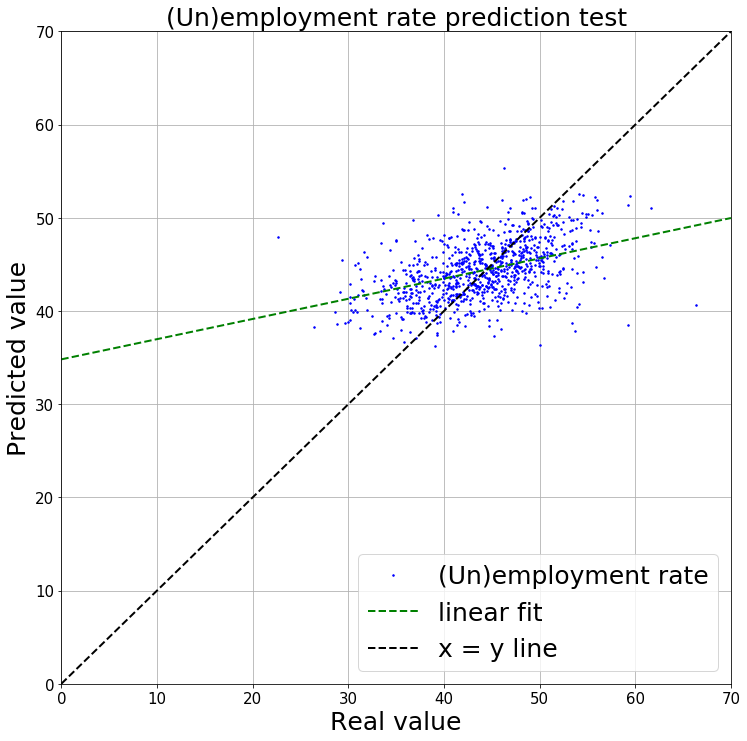

In [72]:
## Init

project_name = "test"
label = "(Un)employment rate"
realVal = y_test
predVal = y_pred

## Plot (real value, predicted value)

# fit_fn is a function which takes in x and returns an estimate for y
fit = np.polyfit(realVal,predVal,1)
fit_fn = np.poly1d(fit)
x = np.linspace(0,100,10000) 

figsize(12,12)
plt.plot(realVal,predVal,color='b',marker='.',ls='',ms=3,label=label)
plt.plot(x,fit_fn(x),color='g',ls='--',lw=2,label='linear fit')
plt.plot(x,x,color='k',ls='--',lw=2,label='x = y line')

plt.title('%s prediction %s' % (label,project_name),fontsize=25)
plt.xlabel('Real value',fontsize=25) 
plt.ylabel('Predicted value',fontsize=25)
plt.legend(loc='lower right',fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)

plt.xlim(0,70)
plt.ylim(0,70);

# plt.text(2, 11, 'Corr = 0.44 +- 0.06',color='b',fontsize=15)
# plt.savefig(project_name+"UnempPred.png",dpi=120);

###  Important features


 24 Important features(> 15 % of max importance):
 Features sorted by importance (DESC):
 [12 15 16 17 18 4 3 1 5 2 11 0 14 21 13 22 6 8 7 19 20 10 9 23]


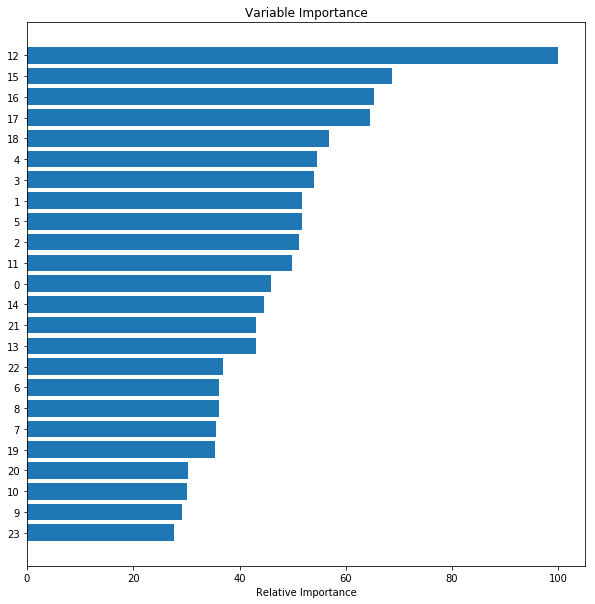

In [73]:

MLalgo = regr_rf
features_list = featuresActiv_list.copy()

# make importances relative to max importance
feature_importance = 100.0 * (MLalgo.feature_importances_ / MLalgo.feature_importances_.max())
 
# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 15
 
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]
 
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
#print ("\n",important_features.shape[0],"Important features(>", fi_threshold, "% of max importance):\n",\important_features)
 
# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print ("\n", important_features.shape[0], "Important features(>", fi_threshold, "% of max importance):\n",
       "Features sorted by importance (DESC):\n", important_features[sorted_idx])
 
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
figsize(12,12)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.rcParams["figure.figsize"]=10,10
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
#plt.show()

# plt.savefig("ActivData01ImpFeatures.png",dpi=120)

In [74]:
###########################################

### Tovabbi iranyok/feladatok:

# kulonbozoen beallitott random forest osszekapcsolasa
# 
# a ket modszer osszekapcsolasa
# 
# ...

###########################################